In [1]:
import nibabel

def load(subject, sequence):
    return nibabel.load(f"3d-dataset/{subject}/{sequence}-T2ROI-32.nii.gz")

In [2]:
import numpy as np

"""
Load from a subject set the 3d cube of tumor for the channel specified
"""
def load_multichannel(dataset, channels):
    result = []
    labels = []
    for label, subject in zip( survivor.iloc[:,2], survivor.iloc[:,1]):
        try:
            row = []

            for channel in channels:
                sequence = load(subject, channel)
                row.append(np.array(sequence.dataobj))
            
            s = np.stack(row, axis=3)
            
            result.append(s)
            labels.append(label)
            
        except FileNotFoundError as e:
            pass    
    return np.array(labels), np.array(result)

In [3]:
def augmentation(data, labels):
    
    augmented_data = []
    augmented_labels = []
    
    for image, label in zip(data, labels):
        
        augmented_data.append(image)
        augmented_labels.append(label)
        
        # Augmentation
        for k in [1, 2, 3]:
            for a in [(0, 1), (0, 2), (1, 2)]:
                row_augmented = np.rot90(image, k=k, axes=a)
                augmented_data.append(row_augmented)
                augmented_labels.append(label)
                
    return np.array(augmented_data), np.array(augmented_labels)

In [4]:
import pandas as pd

survivor = pd.read_csv("datasets/dataset-survivor.csv")

In [5]:
channels = ["T1", "ADC", "FLAIR"]

In [6]:
labels, data = load_multichannel(survivor, channels)

In [7]:
# <Subjects>, <X side>, <Y side>, <Z side>, <Channels: T1, ADC, FLAIR>
data.shape, labels.shape

((120, 32, 32, 32, 3), (120,))

In [8]:
from sklearn.model_selection import train_test_split

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42) # stratify=labels

In [9]:
augmented_train_X, augmented_train_label = augmentation(trainX, trainY)

In [10]:
augmented_train_X.shape, augmented_train_label.shape

((960, 32, 32, 32, 3), (960,))

In [11]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

le = LabelEncoder().fit(labels)

augmented_train_Y = to_categorical(le.transform(augmented_train_label), 2)

Using TensorFlow backend.


In [12]:
test_Y = to_categorical(le.transform(testY), 2)

# 3D CNN

In [13]:
'''Modules needed'''

import tensorflow as tf
from keras.models import Sequential

from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv3D, MaxPooling3D, BatchNormalization
from tensorflow.keras import regularizers

from keras.optimizers import Adam, SGD

from keras import backend as K

In [14]:
# Get shape of input data
data_shape = tuple(data.shape[1:])
print(data_shape)

# Specify shape of convolution kernel
kernel_size = (3, 3, 3)

# Specify number of output categories
n_classes = 2

# Specify number of filters per layer
filters = 32  # For better results, increase this value to 8

(32, 32, 32, 3)


In [28]:
K.clear_session()
model = Sequential()

model = Sequential()

model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', use_bias=True, input_shape=data_shape, kernel_regularizer=regularizers.l2(0.0005)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))

model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', use_bias=True, kernel_regularizer=regularizers.l2(0.0005)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))

model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', use_bias=True, kernel_regularizer=regularizers.l2(0.0005)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

# optimizer
learning_rate = 0.0005
adam = Adam(lr=learning_rate)
sgd = SGD(lr=learning_rate,decay=0.0001/400,momentum=0.9)

model.compile(loss='binary_crossentropy', # categorical_crossentropy', # ',
              optimizer=adam,
              metrics=['accuracy','binary_crossentropy', 'categorical_crossentropy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 30, 30, 32)    2624      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 15, 15, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 15, 32)    128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 15, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 13, 13, 13, 64)    55360     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 6, 6, 6, 64)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 6, 6, 6, 64)      

In [29]:
nEpochs = 5000  # Increase this value for better results (i.e., more training)

batch_size = 16  # Increasing this value might speed up fitting

In [31]:
'''Model fitting'''
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/scalars/modello-3D")

In [32]:
fit = model.fit(augmented_train_X, augmented_train_Y, validation_data=(testX, test_Y), epochs=nEpochs, callbacks=[early_stop_callback, tensorboard_callback], batch_size=batch_size)

Train on 960 samples, validate on 24 samples
Epoch 1/5000
960/960 [==============================] - 6s 7ms/step - loss: 1.3447 - accuracy: 0.5281 - binary_crossentropy: 1.2878 - categorical_crossentropy: 1.2932 - val_loss: 0.8027 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.7452 - val_categorical_crossentropy: 0.7452
Epoch 2/5000
960/960 [==============================] - 3s 4ms/step - loss: 1.2470 - accuracy: 0.5208 - binary_crossentropy: 1.1891 - categorical_crossentropy: 1.2002 - val_loss: 0.7257 - val_accuracy: 0.5833 - val_binary_crossentropy: 0.6676 - val_categorical_crossentropy: 0.6676
Epoch 3/5000
960/960 [==============================] - 3s 3ms/step - loss: 1.0064 - accuracy: 0.5417 - binary_crossentropy: 0.9481 - categorical_crossentropy: 0.9481 - val_loss: 0.7018 - val_accuracy: 0.5833 - val_binary_crossentropy: 0.6433 - val_categorical_crossentropy: 0.6433
Epoch 4/5000
960/960 [==============================] - 3s 3ms/step - loss: 1.0546 - accuracy: 0.5281 - binar

Epoch 30/5000
960/960 [==============================] - 3s 3ms/step - loss: 0.6816 - accuracy: 0.6865 - binary_crossentropy: 0.6208 - categorical_crossentropy: 0.6208 - val_loss: 0.7442 - val_accuracy: 0.6250 - val_binary_crossentropy: 0.6834 - val_categorical_crossentropy: 0.6834
Epoch 31/5000
960/960 [==============================] - 3s 4ms/step - loss: 0.6532 - accuracy: 0.6938 - binary_crossentropy: 0.5925 - categorical_crossentropy: 0.5925 - val_loss: 0.6808 - val_accuracy: 0.6667 - val_binary_crossentropy: 0.6201 - val_categorical_crossentropy: 0.6201
Epoch 32/5000
960/960 [==============================] - 3s 3ms/step - loss: 0.6466 - accuracy: 0.7240 - binary_crossentropy: 0.5858 - categorical_crossentropy: 0.5858 - val_loss: 0.6751 - val_accuracy: 0.6667 - val_binary_crossentropy: 0.6143 - val_categorical_crossentropy: 0.6143
Epoch 33/5000
960/960 [==============================] - 4s 4ms/step - loss: 0.6625 - accuracy: 0.6802 - binary_crossentropy: 0.6017 - categorical_cros

Epoch 59/5000
960/960 [==============================] - 4s 4ms/step - loss: 0.5108 - accuracy: 0.7885 - binary_crossentropy: 0.4486 - categorical_crossentropy: 0.4486 - val_loss: 0.9055 - val_accuracy: 0.5833 - val_binary_crossentropy: 0.8433 - val_categorical_crossentropy: 0.8433
Epoch 60/5000
960/960 [==============================] - 4s 5ms/step - loss: 0.5177 - accuracy: 0.7865 - binary_crossentropy: 0.4555 - categorical_crossentropy: 0.4555 - val_loss: 1.4154 - val_accuracy: 0.7083 - val_binary_crossentropy: 1.3531 - val_categorical_crossentropy: 1.3532
Epoch 61/5000
960/960 [==============================] - 3s 3ms/step - loss: 0.4809 - accuracy: 0.8021 - binary_crossentropy: 0.4186 - categorical_crossentropy: 0.4186 - val_loss: 0.8032 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.7407 - val_categorical_crossentropy: 0.7407
Epoch 62/5000
960/960 [==============================] - 3s 4ms/step - loss: 0.5121 - accuracy: 0.7937 - binary_crossentropy: 0.4497 - categorical_cros

Epoch 88/5000
960/960 [==============================] - 4s 4ms/step - loss: 0.3816 - accuracy: 0.8677 - binary_crossentropy: 0.3122 - categorical_crossentropy: 0.3122 - val_loss: 0.8696 - val_accuracy: 0.6667 - val_binary_crossentropy: 0.7999 - val_categorical_crossentropy: 0.7999
Epoch 89/5000
960/960 [==============================] - 4s 4ms/step - loss: 0.3766 - accuracy: 0.8562 - binary_crossentropy: 0.3065 - categorical_crossentropy: 0.3065 - val_loss: 1.0426 - val_accuracy: 0.5833 - val_binary_crossentropy: 0.9722 - val_categorical_crossentropy: 0.9722
Epoch 90/5000
960/960 [==============================] - 4s 4ms/step - loss: 0.3995 - accuracy: 0.8521 - binary_crossentropy: 0.3291 - categorical_crossentropy: 0.3291 - val_loss: 0.8472 - val_accuracy: 0.7083 - val_binary_crossentropy: 0.7766 - val_categorical_crossentropy: 0.7766
Epoch 91/5000
960/960 [==============================] - 3s 3ms/step - loss: 0.4028 - accuracy: 0.8375 - binary_crossentropy: 0.3320 - categorical_cros

960/960 [==============================] - 3s 4ms/step - loss: 0.3059 - accuracy: 0.9198 - binary_crossentropy: 0.2213 - categorical_crossentropy: 0.2213 - val_loss: 0.9860 - val_accuracy: 0.5417 - val_binary_crossentropy: 0.9011 - val_categorical_crossentropy: 0.9011
Epoch 117/5000
960/960 [==============================] - 3s 4ms/step - loss: 0.3309 - accuracy: 0.9073 - binary_crossentropy: 0.2458 - categorical_crossentropy: 0.2458 - val_loss: 1.2286 - val_accuracy: 0.6250 - val_binary_crossentropy: 1.1433 - val_categorical_crossentropy: 1.1433
Epoch 118/5000
960/960 [==============================] - 3s 4ms/step - loss: 0.3163 - accuracy: 0.9073 - binary_crossentropy: 0.2308 - categorical_crossentropy: 0.2308 - val_loss: 1.2943 - val_accuracy: 0.4583 - val_binary_crossentropy: 1.2085 - val_categorical_crossentropy: 1.2085
Epoch 119/5000
960/960 [==============================] - 4s 4ms/step - loss: 0.2968 - accuracy: 0.9167 - binary_crossentropy: 0.2108 - categorical_crossentropy: 0

Epoch 145/5000
960/960 [==============================] - 3s 3ms/step - loss: 0.2858 - accuracy: 0.9333 - binary_crossentropy: 0.1865 - categorical_crossentropy: 0.1865 - val_loss: 1.7761 - val_accuracy: 0.4583 - val_binary_crossentropy: 1.6765 - val_categorical_crossentropy: 1.6766
Epoch 146/5000
960/960 [==============================] - 4s 4ms/step - loss: 0.2944 - accuracy: 0.9229 - binary_crossentropy: 0.1946 - categorical_crossentropy: 0.1946 - val_loss: 1.7467 - val_accuracy: 0.5000 - val_binary_crossentropy: 1.6466 - val_categorical_crossentropy: 1.6466
Epoch 147/5000
960/960 [==============================] - 4s 4ms/step - loss: 0.2472 - accuracy: 0.9385 - binary_crossentropy: 0.1470 - categorical_crossentropy: 0.1470 - val_loss: 1.5131 - val_accuracy: 0.5417 - val_binary_crossentropy: 1.4129 - val_categorical_crossentropy: 1.4129
Epoch 148/5000
960/960 [==============================] - 4s 4ms/step - loss: 0.2695 - accuracy: 0.9292 - binary_crossentropy: 0.1691 - categorical_

Epoch 174/5000
960/960 [==============================] - 4s 4ms/step - loss: 0.2380 - accuracy: 0.9479 - binary_crossentropy: 0.1277 - categorical_crossentropy: 0.1277 - val_loss: 2.1994 - val_accuracy: 0.4167 - val_binary_crossentropy: 2.0890 - val_categorical_crossentropy: 2.0892
Epoch 175/5000
960/960 [==============================] - 3s 3ms/step - loss: 0.2654 - accuracy: 0.9438 - binary_crossentropy: 0.1548 - categorical_crossentropy: 0.1548 - val_loss: 2.4414 - val_accuracy: 0.4583 - val_binary_crossentropy: 2.3305 - val_categorical_crossentropy: 2.3321
Epoch 176/5000
960/960 [==============================] - 3s 3ms/step - loss: 0.2363 - accuracy: 0.9573 - binary_crossentropy: 0.1252 - categorical_crossentropy: 0.1252 - val_loss: 2.4009 - val_accuracy: 0.5417 - val_binary_crossentropy: 2.2897 - val_categorical_crossentropy: 2.2898
Epoch 177/5000
960/960 [==============================] - 4s 4ms/step - loss: 0.2317 - accuracy: 0.9563 - binary_crossentropy: 0.1204 - categorical_

960/960 [==============================] - 3s 3ms/step - loss: 0.2405 - accuracy: 0.9531 - binary_crossentropy: 0.1222 - categorical_crossentropy: 0.1222 - val_loss: 1.8572 - val_accuracy: 0.7083 - val_binary_crossentropy: 1.7386 - val_categorical_crossentropy: 1.7922
Epoch 203/5000
960/960 [==============================] - 3s 3ms/step - loss: 0.2109 - accuracy: 0.9635 - binary_crossentropy: 0.0924 - categorical_crossentropy: 0.0924 - val_loss: 2.1516 - val_accuracy: 0.4583 - val_binary_crossentropy: 2.0331 - val_categorical_crossentropy: 2.0342
Epoch 204/5000
960/960 [==============================] - 4s 4ms/step - loss: 0.2309 - accuracy: 0.9521 - binary_crossentropy: 0.1122 - categorical_crossentropy: 0.1122 - val_loss: 1.7229 - val_accuracy: 0.5833 - val_binary_crossentropy: 1.6041 - val_categorical_crossentropy: 1.6042
Epoch 205/5000
960/960 [==============================] - 4s 4ms/step - loss: 0.2409 - accuracy: 0.9510 - binary_crossentropy: 0.1219 - categorical_crossentropy: 0

Epoch 231/5000
960/960 [==============================] - 4s 4ms/step - loss: 0.2565 - accuracy: 0.9490 - binary_crossentropy: 0.1320 - categorical_crossentropy: 0.1320 - val_loss: 1.7264 - val_accuracy: 0.6250 - val_binary_crossentropy: 1.6018 - val_categorical_crossentropy: 1.6020
Epoch 232/5000
960/960 [==============================] - 4s 4ms/step - loss: 0.2154 - accuracy: 0.9646 - binary_crossentropy: 0.0909 - categorical_crossentropy: 0.0909 - val_loss: 2.2044 - val_accuracy: 0.5000 - val_binary_crossentropy: 2.0799 - val_categorical_crossentropy: 2.0801
Epoch 233/5000
960/960 [==============================] - 4s 4ms/step - loss: 0.2052 - accuracy: 0.9750 - binary_crossentropy: 0.0806 - categorical_crossentropy: 0.0806 - val_loss: 2.4337 - val_accuracy: 0.4167 - val_binary_crossentropy: 2.3092 - val_categorical_crossentropy: 2.3130
Epoch 234/5000
960/960 [==============================] - 3s 4ms/step - loss: 0.2273 - accuracy: 0.9688 - binary_crossentropy: 0.1026 - categorical_

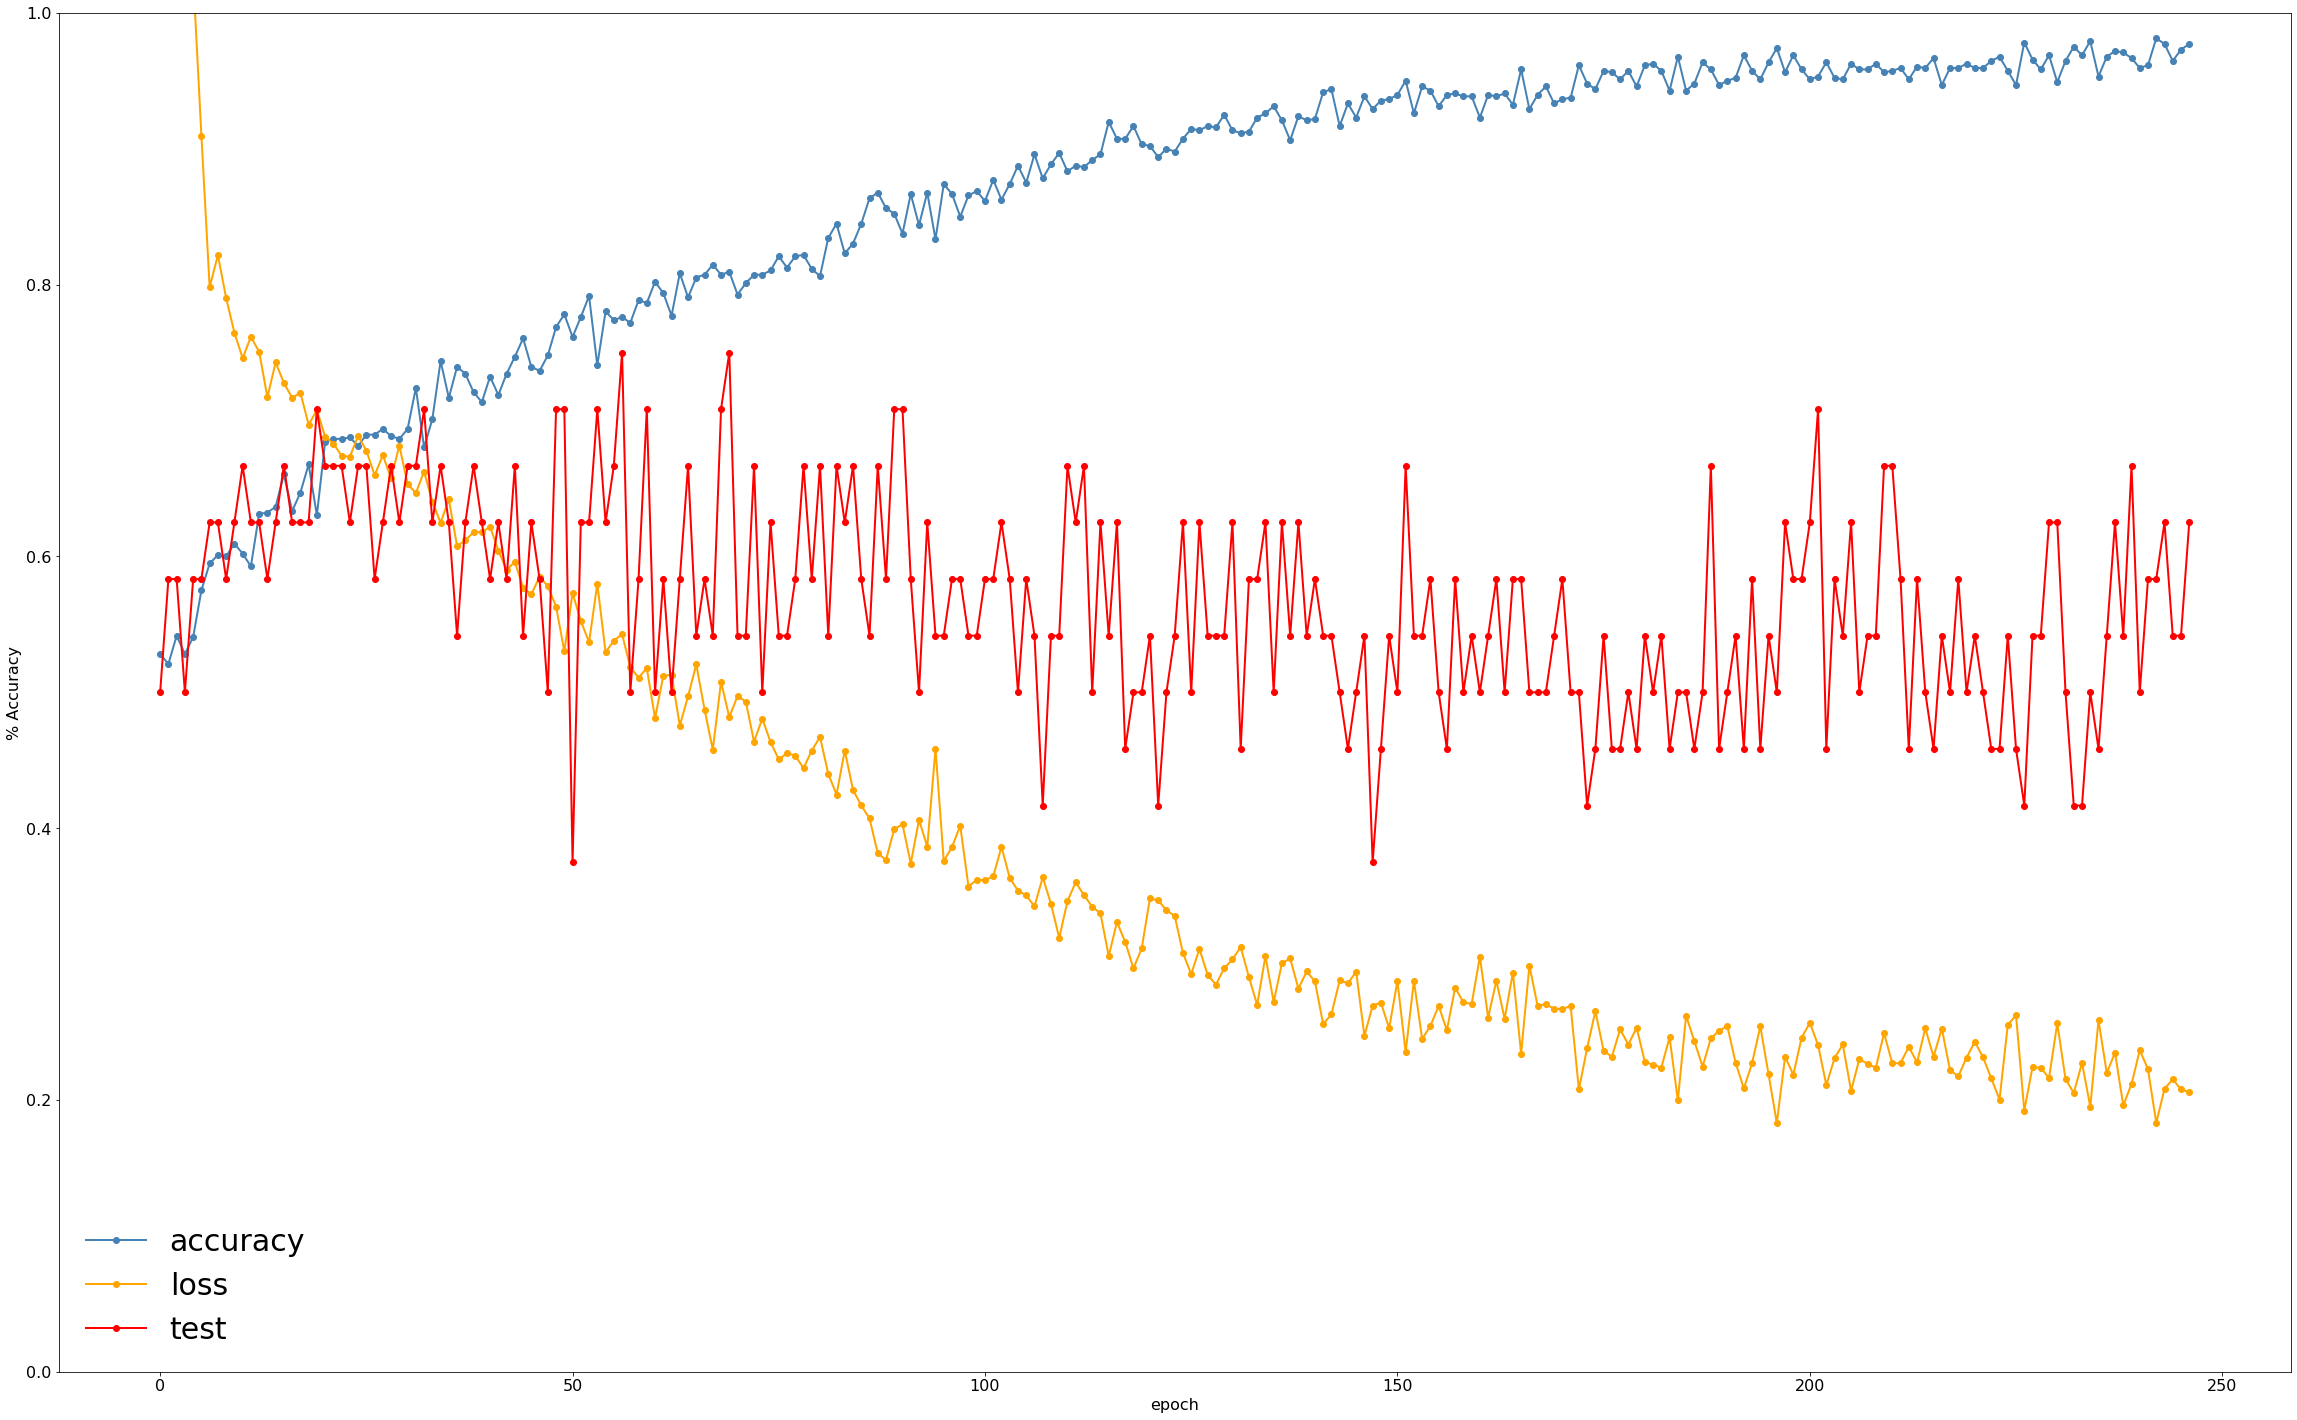

In [33]:
import pylab as plt

fig = plt.figure(figsize=(40, 25))
epoch = range(len(fit.history['accuracy']))
fontsize = 16
plt.plot(epoch, fit.history['accuracy'], marker="o", linewidth=2, color="steelblue", label="accuracy")
plt.plot(epoch, fit.history['loss'], marker="o", linewidth=2, color="orange", label="loss")
plt.plot(epoch, fit.history['val_accuracy'], marker="o", linewidth=2, color="red", label="test")
# plt.plot(epoch, fit.history['val_binary_crossentropy'], marker="o", linewidth=2, color="green", label="binary_crossentropy")
plt.xlabel('epoch', fontsize=fontsize)
plt.ylabel('% Accuracy', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylim(0, 1)
plt.legend(frameon=False, fontsize=30);

In [34]:
np.max(fit.history['val_accuracy']), np.min(fit.history['val_accuracy']), np.average(fit.history['val_accuracy'])

(0.75, 0.375, 0.5671390040442046)

In [35]:
scores = model.evaluate(testX, test_Y, verbose=0)
print("%s on test data: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy on test data: 62.50%
